In [1]:
import numpy as np
import pandas as pd
import json
import os
import pennylane as qml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
cobyla_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\VQE\OptimizerComparison\COBYLA\All"
de_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\VQE\Differential Evolution\RealAmplitudes\DevTimes"
adapt_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\VQE\Differential Evolution\ADAPT\DevTimes"

potentials = ['QHO', 'AHO', 'DW']

cutoffs = [2, 4, 8, 16, 32, 64, 128]

In [3]:
def get_data(path, is_de, converged_only=True):

    evals = {potential: [] for potential in potentials}
    evals_min = {potential: [] for potential in potentials}
    evals_max = {potential: [] for potential in potentials}

    times = {potential: [] for potential in potentials}
    lower_std = {potential: [] for potential in potentials}
    upper_std = {potential: [] for potential in potentials}

    delta_e = {potential: [] for potential in potentials}

    for potential in potentials:
        for cutoff in cutoffs:

            file_path = os.path.join(path, potential, f"{potential}_{cutoff}.json")
            
            with open(file_path, 'r') as f:
                data = json.load(f)

            converged_indices = [i for i, success in enumerate(data['success']) if success]

            if converged_only:
                run_times = [data['run_times'][i] for i in converged_indices]
                if is_de:
                    evals_d = [data['num_evaluations'][i] for i in converged_indices]
                else:
                    evals_d = [data['num_iters'][i] for i in converged_indices]
    
            else:
                run_times = data['run_times']
                if is_de:
                    evals_d = data['num_evaluations']
                else:
                    evals_d = data['num_iters']
                
            
            time_series = np.array([pd.Timedelta(t).seconds for t in run_times])
            mean_vqe_time = np.mean(time_series)
            times[potential].append(mean_vqe_time)

            #std_vqe_time = np.std(t_sec)
            ustd = np.std(time_series[time_series >= mean_vqe_time], ddof=1)
            lstd = np.std(time_series[time_series <= mean_vqe_time], ddof=1)
            lower_std[potential].append(lstd)
            upper_std[potential].append(ustd)

            mean_evals = np.mean(evals_d)
            min_evals = np.min(evals_d)
            max_evals = np.max(evals_d)
            evals[potential].append(mean_evals)
            evals_min[potential].append(min_evals)
            evals_max[potential].append(max_evals)
            
            exact_min_e = np.min(data['exact_eigenvalues'])
            median_e = np.mean([data['results'][i] for i in converged_indices])
            delta_median_e = (abs(exact_min_e - median_e)) 
            delta_e[potential].append(delta_median_e)

    return times, lower_std, upper_std, delta_e, evals, evals_min, evals_max

In [4]:
converged_only = False
cobyla_times, cobyla_lower_std, cobyla_upper_std, cobyla_delta_e, cobyla_evals, cobyla_evals_min, cobyla_evals_max = get_data(cobyla_path, is_de=False, converged_only=converged_only)
de_times, de_lower_std, de_upper_std, de_delta_e, de_evals, de_evals_min, de_evals_max = get_data(de_path, is_de=True, converged_only=converged_only)
adapt_times, adapt_lower_std, adapt_upper_std, adapt_delta_e, adapt_evals, adapt_evals_min, adapt_evals_max = get_data(adapt_path, is_de=True, converged_only=converged_only)

c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


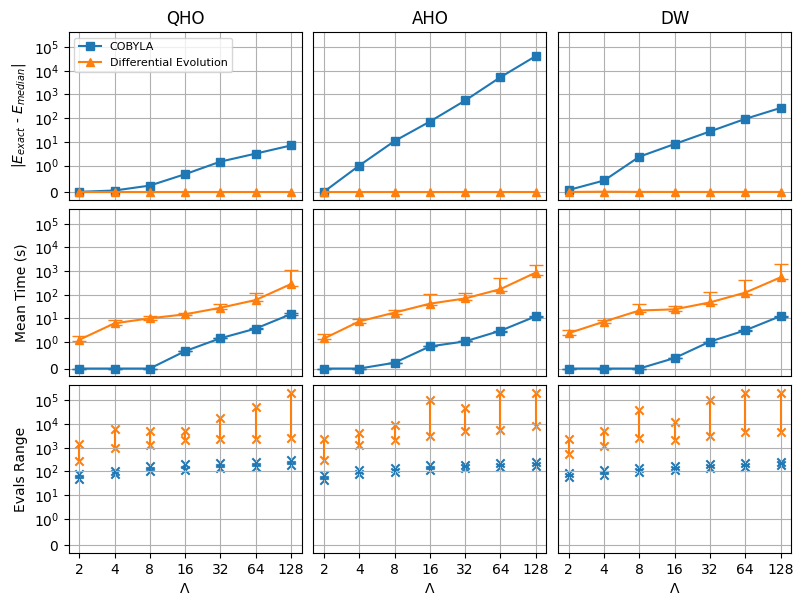

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(8, 6), sharey=True, sharex=True)

for i, potential in enumerate(potentials):
    axs = axes[0, i]
    axs.plot(cutoffs, cobyla_delta_e[potential], marker='s', label='COBYLA')
    axs.plot(cutoffs, de_delta_e[potential], marker='^', label='Differential Evolution')
    axs.set_title(f'{potential}')
    axs.set_yscale('symlog', linthresh=1)
    axs.grid(True)
    
    if i == 0:
        axs.set_ylabel('|$E_{exact}$ - $E_{median}$|')
        axs.legend(loc='upper left', fontsize=8)
    else:
        axs.tick_params(axis='y', left=False, right=False, labelleft=False)
    
    #axs.tick_params(labelbottom=False)
    axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

for i, potential in enumerate(potentials):
    axs = axes[1, i]
    axs.errorbar(cutoffs, cobyla_times[potential], yerr=[cobyla_lower_std[potential], cobyla_upper_std[potential]],marker='s', capsize=5, label='COBYLA')
    axs.errorbar(cutoffs, de_times[potential], yerr=[de_lower_std[potential], de_upper_std[potential]],marker='^', capsize=5, label='Differential Evolution')
    #axs.set_xlabel('$\\Lambda$')
    axs.set_yscale('symlog', linthresh=1)
    axs.grid(True)

    if i == 0:
        axs.set_ylabel('Mean Time (s)')
    else:
        axs.tick_params(axis='y', left=False, right=False, labelleft=False)

    axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

for i, potential in enumerate(potentials):
    axs = axes[2, i]
    
    for j, x in enumerate(cutoffs):
        min_val = cobyla_evals_min[potential][j]
        max_val = cobyla_evals_max[potential][j]
        mean_val = cobyla_evals[potential][j]
        axs.vlines(x=x, ymin=min_val, ymax=max_val, color='tab:blue')
        axs.scatter(x, min_val, color='tab:blue', marker='x')
        axs.scatter(x, max_val, color='tab:blue', marker='x')

    for j, x in enumerate(cutoffs):
        min_val = de_evals_min[potential][j]
        max_val = de_evals_max[potential][j]
        mean_val = de_evals[potential][j]
        axs.vlines(x=x, ymin=min_val, ymax=max_val, color='tab:orange')
        axs.scatter(x, min_val, color='tab:orange', marker='x')
        axs.scatter(x, max_val, color='tab:orange', marker='x')

    axs.set_xlabel('$\\Lambda$')
    axs.set_yscale('symlog', linthresh=1)
    #axs.set_xscale('log')  # Ensure consistent x-axis
    axs.grid(True)

    if i == 0:
        axs.set_ylabel('Evals Range')
    else:
        axs.tick_params(axis='y', left=False, right=False, labelleft=False)

axes[1, 0].set_xscale('log')
axes[1, 0].set_xticks(cutoffs)
axes[1, 0].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1, 0].xaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout(pad=0.5)
plt.show()


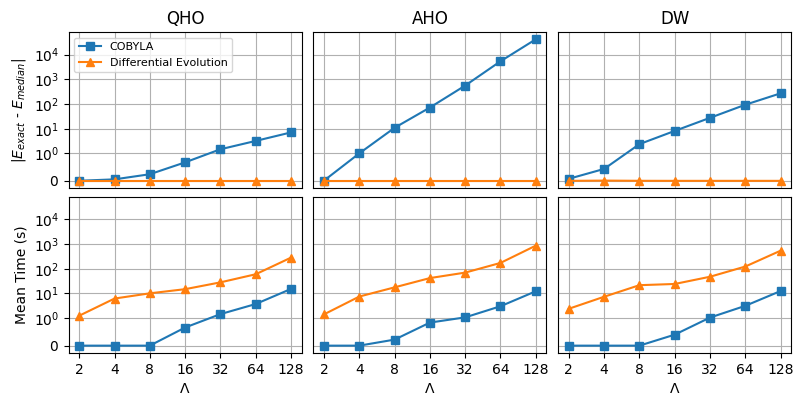

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4), sharey=True, sharex=True)#, gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, potential in enumerate(potentials):
    axs = axes[0, i]
    axs.plot(cutoffs, cobyla_delta_e[potential], marker='s', label='COBYLA')
    axs.plot(cutoffs, de_delta_e[potential], marker='^', label='Differential Evolution')
    axs.set_title(f'{potential}')
    axs.set_yscale('symlog', linthresh=1)
    axs.grid(True)
    
    if i == 0:
        axs.set_ylabel('|$E_{exact}$ - $E_{median}$|')
        axs.legend(loc='upper left', fontsize=8)
    else:
        axs.tick_params(axis='y', left=False, right=False, labelleft=False)
    
    #axs.tick_params(labelbottom=False)
    axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

for i, potential in enumerate(potentials):
    axs = axes[1, i]
    #axs.errorbar(cutoffs, cobyla_times[potential], yerr=[cobyla_lower_std[potential], cobyla_upper_std[potential]],marker='s', capsize=5, label='COBYLA')
    #axs.errorbar(cutoffs, de_times[potential], yerr=[de_lower_std[potential], de_upper_std[potential]],marker='^', capsize=5, label='Differential Evolution')
    axs.plot(cutoffs, cobyla_times[potential],marker='s', label='COBYLA')
    axs.plot(cutoffs, de_times[potential], marker='^', label='Differential Evolution')
    axs.set_xlabel('$\\Lambda$')
    #axs.set_yscale('symlog', linthresh=1)
    axs.grid(True)

    if i == 0:
        axs.set_ylabel('Mean Time (s)')
    else:
        axs.tick_params(axis='y', left=False, right=False, labelleft=False)

axes[1, 0].set_xscale('log')
axes[1, 0].set_xticks(cutoffs)
axes[1, 0].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1, 0].xaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout(pad=0.5)
plt.show()


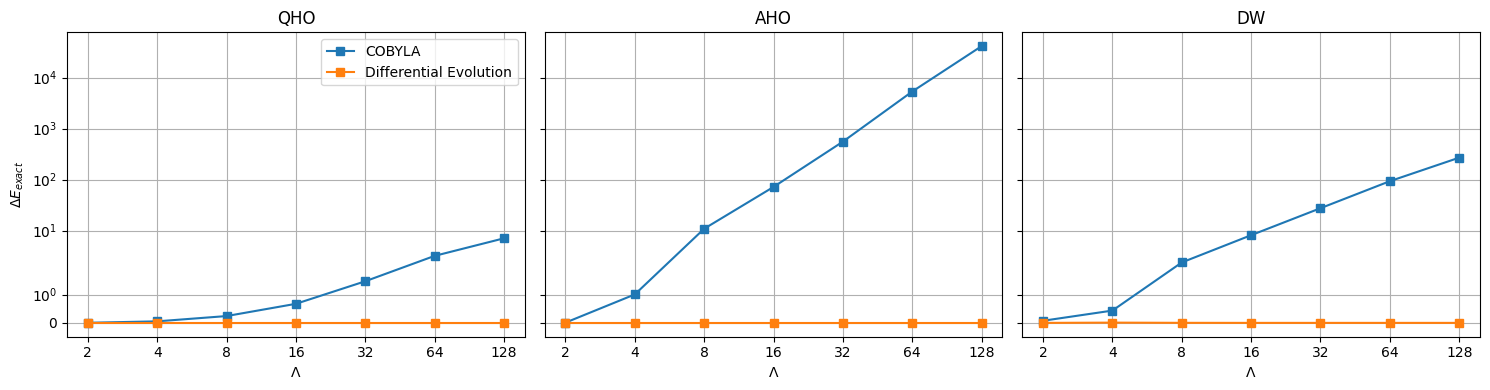

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, potential in enumerate(potentials):
    axs[i].plot(cutoffs, cobyla_delta_e[potential], marker='s', label='COBYLA')
    axs[i].plot(cutoffs, de_delta_e[potential], marker='s', label='Differential Evolution')
    axs[i].set_title(f'{potential}')
    axs[i].set_xlabel('$\\Lambda$')
    axs[i].set_xscale('log')
    axs[i].set_yscale('symlog')
    axs[i].set_xticks(cutoffs)
    axs[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
    axs[i].xaxis.set_minor_locator(ticker.NullLocator())
    axs[i].ticklabel_format(style='plain', axis='x')
    axs[i].grid(True)
    
    if i == 0:
        axs[i].set_ylabel('$\\Delta$'+'$E_{exact}$')
        axs[i].legend()

plt.tight_layout()
plt.show()


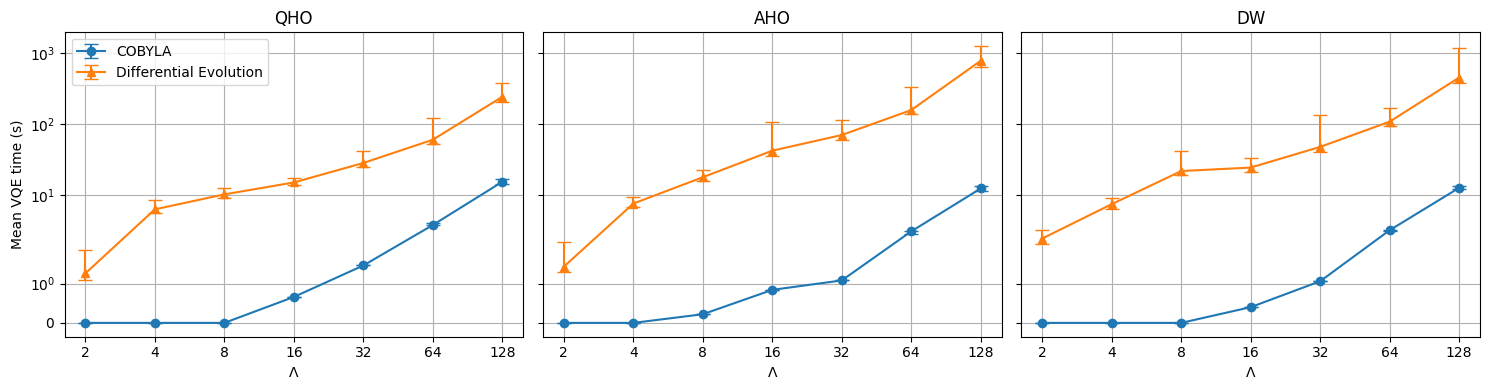

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, potential in enumerate(potentials):
    axs[i].errorbar(cutoffs, cobyla_times[potential], yerr=[cobyla_lower_std[potential],cobyla_upper_std[potential]], marker='o', capsize=5, label='COBYLA')
    axs[i].errorbar(cutoffs, de_times[potential], yerr=[de_lower_std[potential],de_upper_std[potential]],marker='^', capsize=5, label='Differential Evolution')
    axs[i].set_title(f'{potential}')
    axs[i].set_xlabel('$\\Lambda$')
    axs[i].set_xscale('log')
    axs[i].set_yscale('symlog')
    axs[i].set_xticks(cutoffs)
    axs[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
    axs[i].xaxis.set_minor_locator(ticker.NullLocator())
    axs[i].ticklabel_format(style='plain', axis='x')
    axs[i].grid(True)
    
    if i == 0:
        axs[i].set_ylabel('Mean VQE time (s)')
        axs[i].legend()

plt.tight_layout()
plt.show()


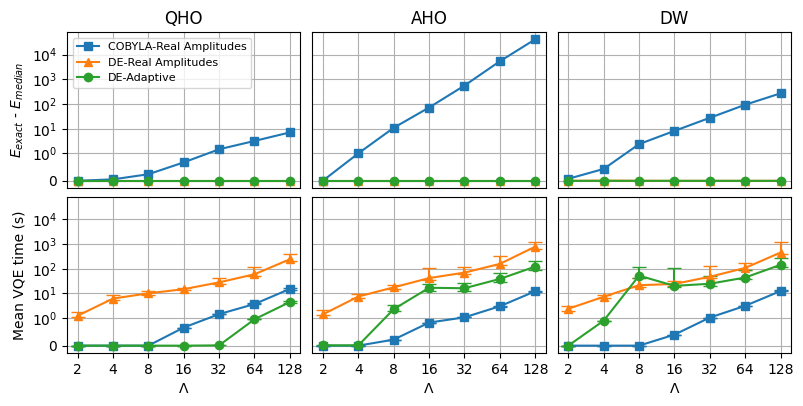

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4), sharey=True, sharex=True)

for i, potential in enumerate(potentials):
    axs = axes[0, i]
    axs.plot(cutoffs, cobyla_delta_e[potential], marker='s', label='COBYLA-Real Amplitudes')
    axs.plot(cutoffs, de_delta_e[potential], marker='^', label='DE-Real Amplitudes')
    axs.plot(cutoffs, adapt_delta_e[potential], marker='o', label='DE-Adaptive')
    axs.set_title(f'{potential}')
    axs.set_yscale('symlog', linthresh=1)
    axs.grid(True)
    
    if i == 0:
        axs.set_ylabel('$E_{exact}$ - $E_{median}$')
        axs.legend(loc='upper left', fontsize=8)
    else:
        axs.tick_params(axis='y', left=False, right=False, labelleft=False)
    
    #axs.tick_params(labelbottom=False)
    axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

for i, potential in enumerate(potentials):
    axs = axes[1, i]
    axs.errorbar(cutoffs, cobyla_times[potential], yerr=[cobyla_lower_std[potential], cobyla_upper_std[potential]],marker='s', capsize=5, label='COBYLA-Real Amplitudes')
    axs.errorbar(cutoffs, de_times[potential], yerr=[de_lower_std[potential], de_upper_std[potential]],marker='^', capsize=5, label='DE-Real Amplitudes')
    axs.errorbar(cutoffs, adapt_times[potential], yerr=[adapt_lower_std[potential], adapt_upper_std[potential]],marker='o', capsize=5, label='DE-Adaptive')
    axs.set_xlabel('$\\Lambda$')
    axs.set_yscale('symlog', linthresh=1)
    axs.grid(True)

    if i == 0:
        axs.set_ylabel('Mean VQE time (s)')
    else:
        axs.tick_params(axis='y', left=False, right=False, labelleft=False)

axes[1, 0].set_xscale('log')
axes[1, 0].set_xticks(cutoffs)
axes[1, 0].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1, 0].xaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout(pad=0.5)
plt.show()
